# DQL for snake game
using board (matrix) as input, CNN, so no reward nor state, only scores and gameover

In [1]:
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
import time 

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
#import torchvision.transforms as T

from snake import SnakeGame
from IPython.display import clear_output
from IPython.display import Image
import os
import matplotlib.animation as animation
import matplotlib.image as image
from matplotlib import rc

from Train_network import ReplayMemory,DQN,Transition,get_memory

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = "0" 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Text(0, 0.5, 'mean snake lenghth')

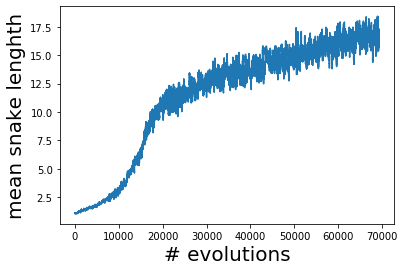

In [3]:
final_len=np.load("final_len.npy")
step = 100
tmp = [np.mean(final_len[i:i+step]) for i in range(len(final_len)-step)]
plt.plot(tmp,"-")
plt.xlabel("# evolutions",size=20)
plt.ylabel("mean snake lenghth",size=20)


In [4]:
game_size = 16 +2 #(+2 for bundary)
time_window = 2
n_actions = 4 # up down left right

In [5]:
target_net = DQN(time_window, game_size , game_size , n_actions).to(device)
target_net.load_state_dict(torch.load("policy_net.pth"))
target_net.eval()

DQN(
  (conv1): Conv3d(1, 128, kernel_size=(1, 5, 5), stride=(1, 1, 1))
  (conv2): Conv3d(128, 128, kernel_size=(1, 5, 5), stride=(1, 1, 1))
  (conv3): Conv3d(128, 128, kernel_size=(1, 3, 3), stride=(1, 1, 1))
  (conv4): Conv3d(128, 128, kernel_size=(1, 3, 3), stride=(1, 1, 1))
  (head): Linear(in_features=9216, out_features=4, bias=True)
)

In [6]:
def select_action(state):
    with torch.no_grad():
        return target_net(state).max(1)[1].view(1, 1)


In [7]:
def AI_play(mode="easy",wait=0.1,size=game_size,cutoff=float("inf"),repeat=100):
    #print("I want to play a game")
    best=0
    best_ims=[]
    for _ in range(repeat):
        if(_%10==0):print(_)
        game = SnakeGame(size, size,mode)
        #game.display()
        gameOver=False
        reward=0
        score=0
        #print("Score:",score)
        ims = []
        step=0
        score_record= []
        memory_board = np.zeros((time_window,game_size,game_size))
        while True:
            step+=1
            if(step>cutoff):break
            #clear_output(wait=True)
            state,memory_board=get_memory(memory_board,game,device)
            action = select_action(state)
            _, _, gameOver, score = game.makeMove(action.item())

            if score==(size-2)**2:
                #print("Perfect") #score  = lenghth of the snake
                break

            score_record+=[score]
            if(len(score_record)>100 and score_record[-1]<=score_record[-100]):
                #print("stuck")
                break

            if gameOver:
                break
            else:
                pass
                #game.display()
                #print("Score:", score)

            #time.sleep(wait)
            tmp = np.asarray(np.copy(game.getBoard()),dtype="float32")

            #tmp+=1.0
            #tmp/=5.0
            #tmp*=255.0

            ims+=[tmp]
            #print(ims)
        if(score>best):
            best=score
            best_ims=ims[:]
    print("Game Over, best Score:", best)
    print("frame:", len(best_ims))
    return best_ims

In [8]:
ims = AI_play(mode="hard",wait=0,cutoff=1000)

0
10
20
30
40
50
60
70
80
90
Game Over, best Score: 34
frame: 385


rm: cannot remove 'ani_data/*.png': No such file or directory


/home/sam/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


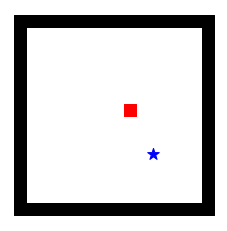

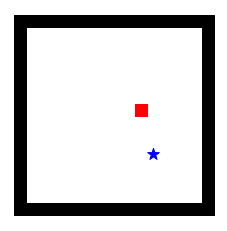

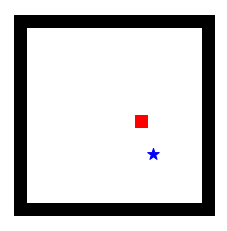

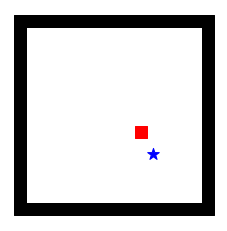

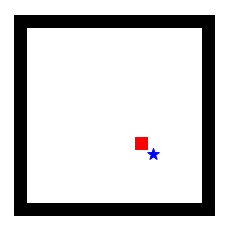

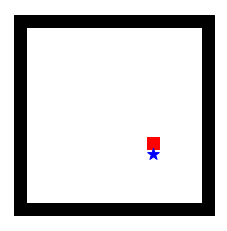

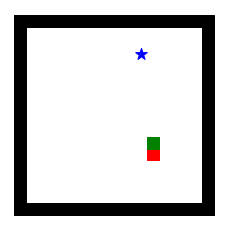

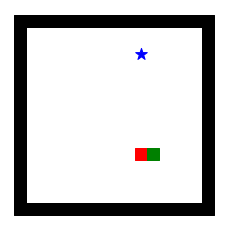

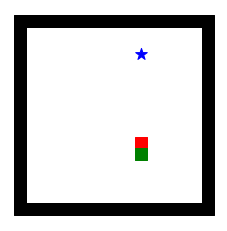

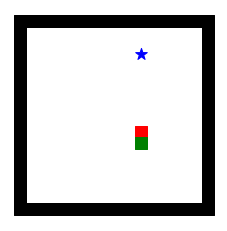

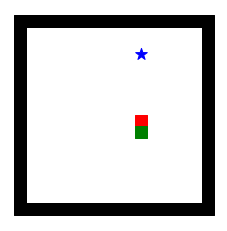

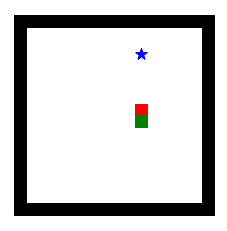

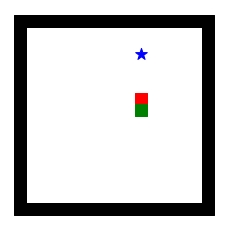

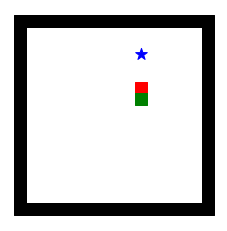

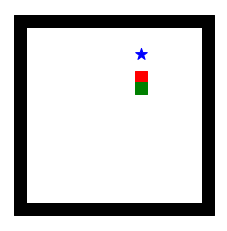

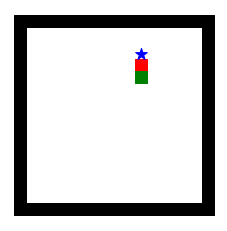

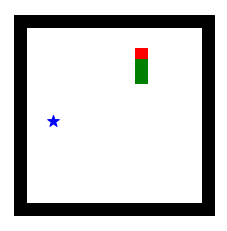

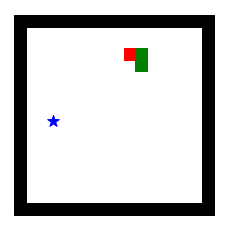

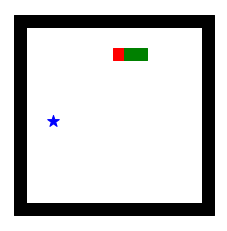

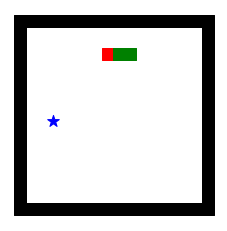

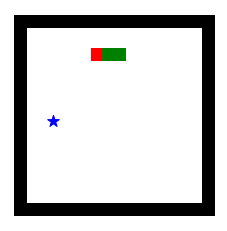

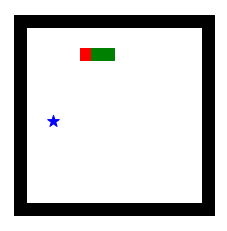

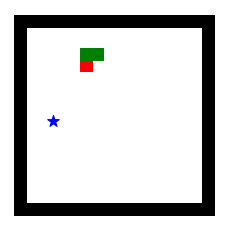

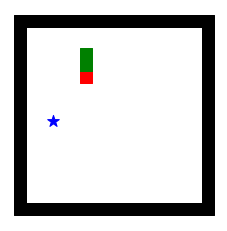

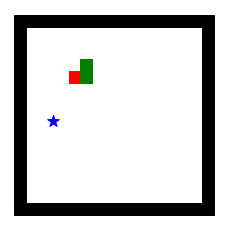

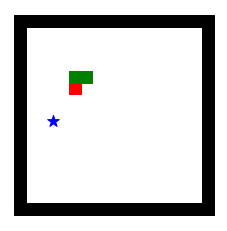

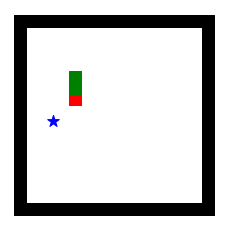

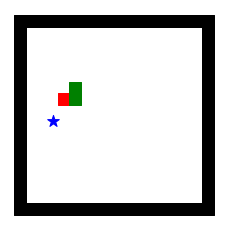

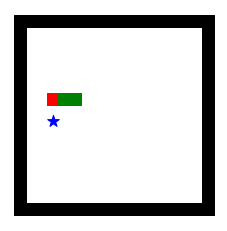

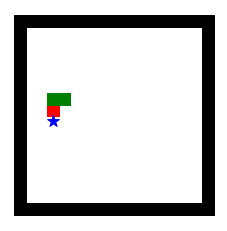

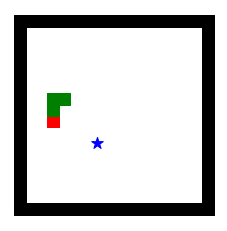

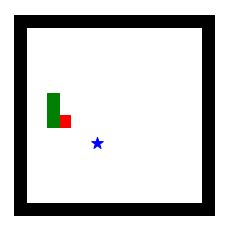

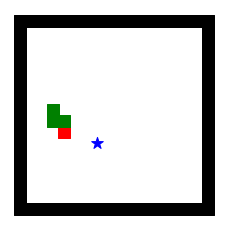

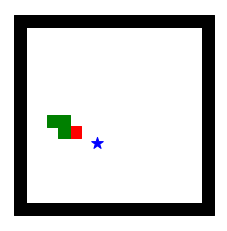

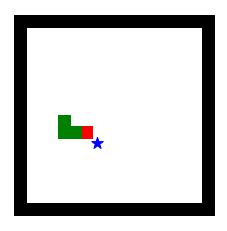

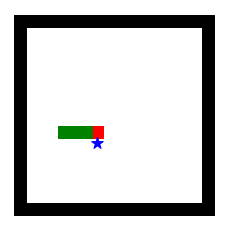

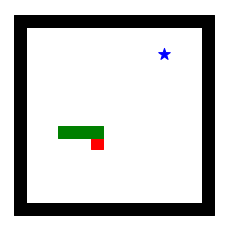

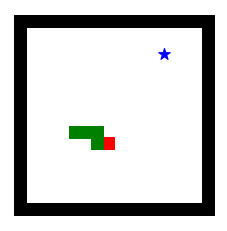

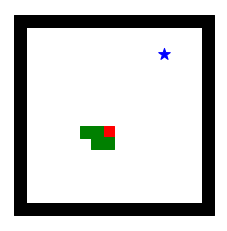

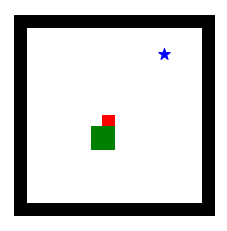

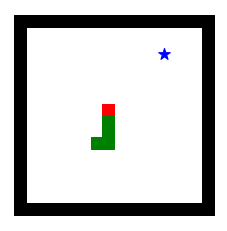

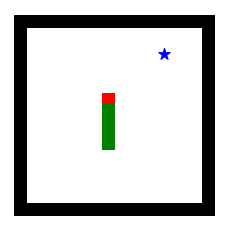

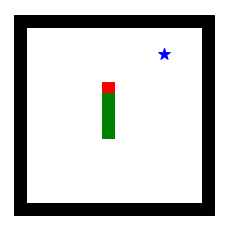

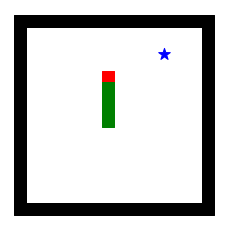

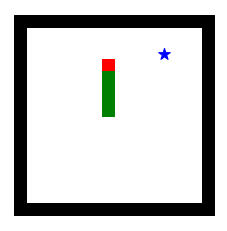

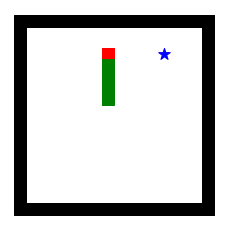

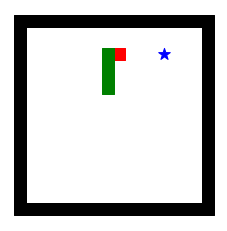

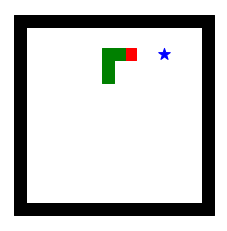

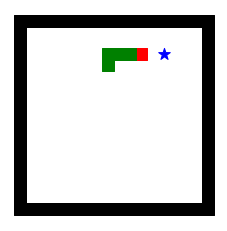

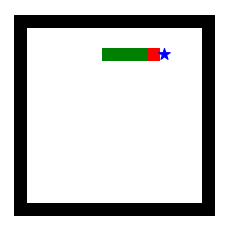

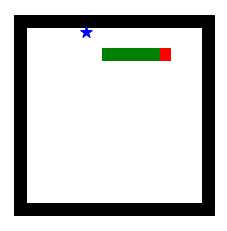

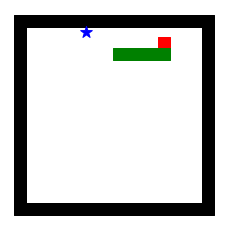

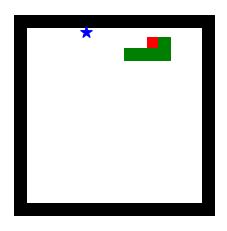

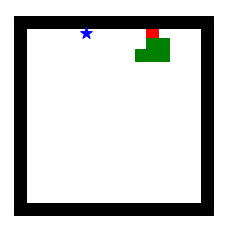

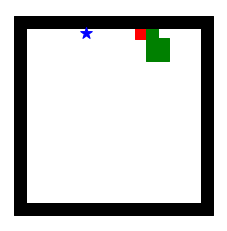

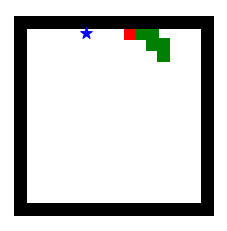

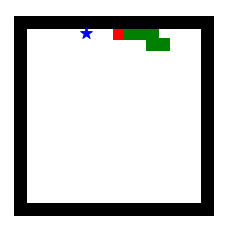

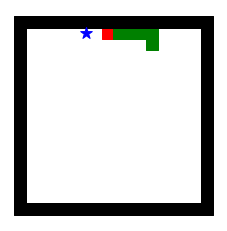

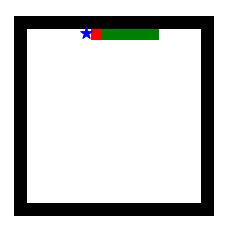

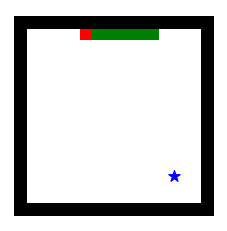

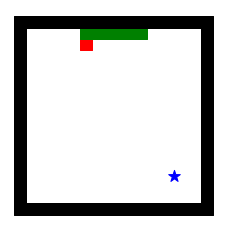

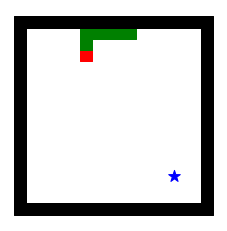

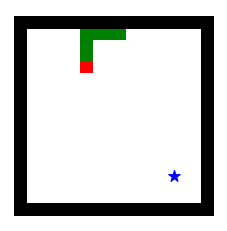

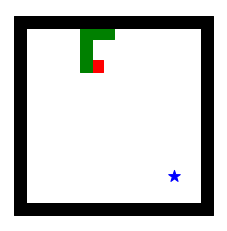

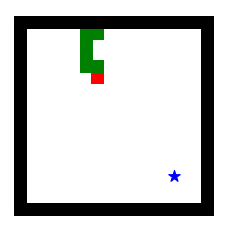

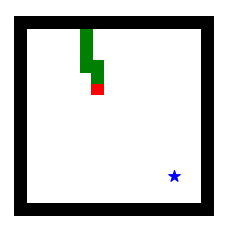

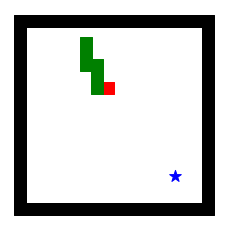

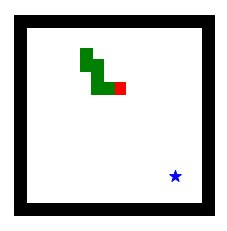

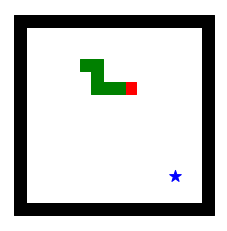

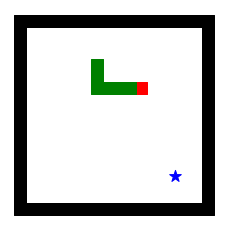

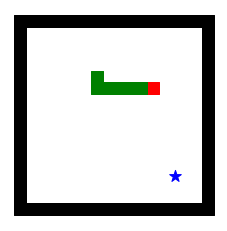

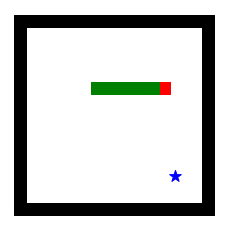

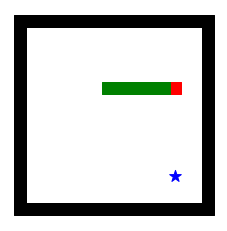

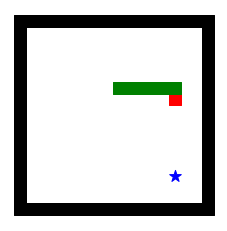

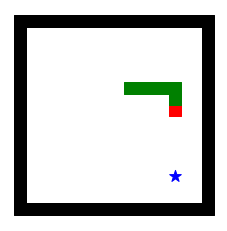

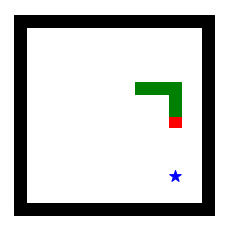

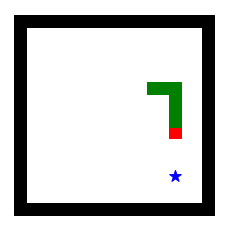

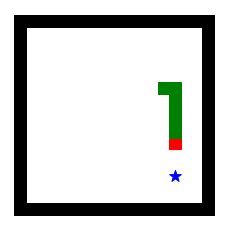

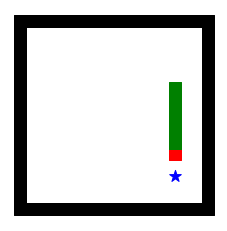

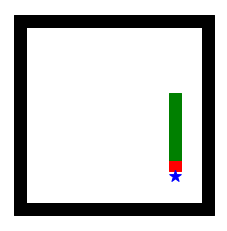

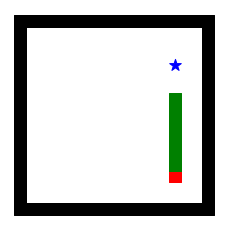

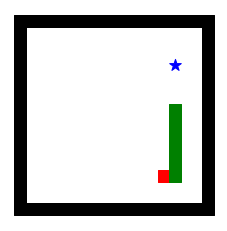

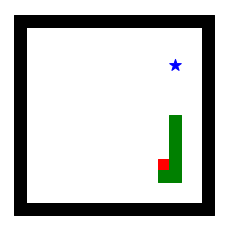

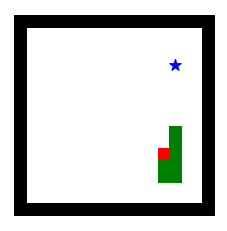

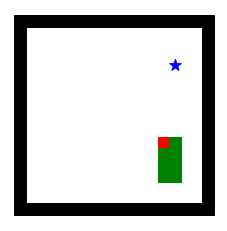

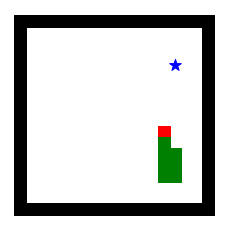

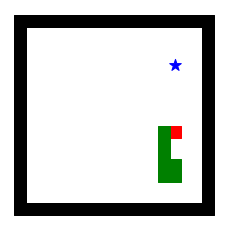

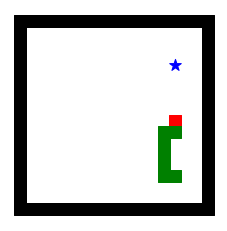

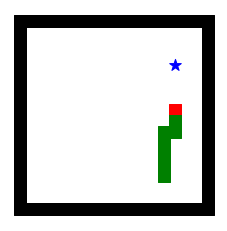

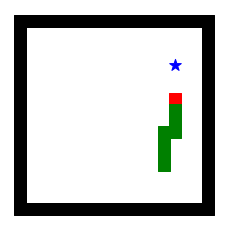

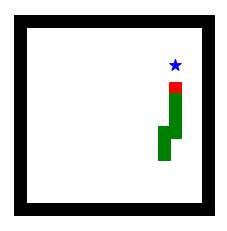

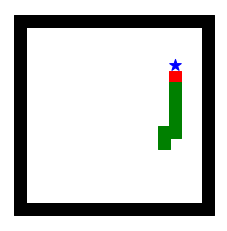

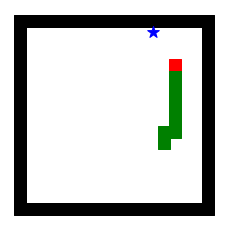

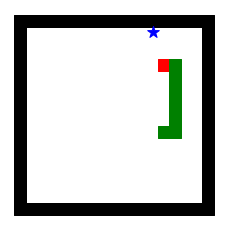

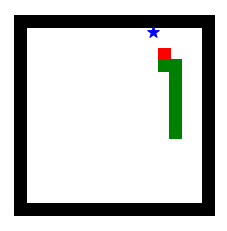

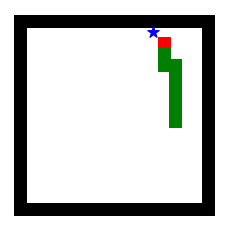

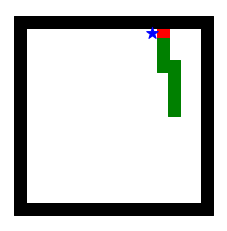

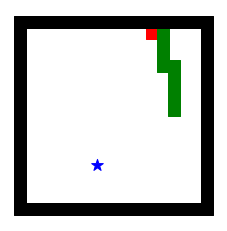

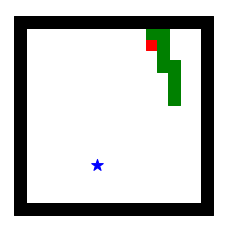

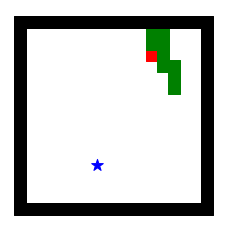

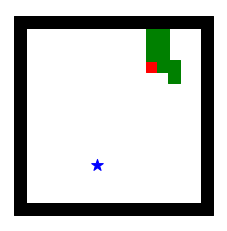

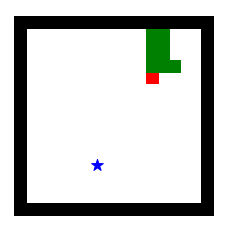

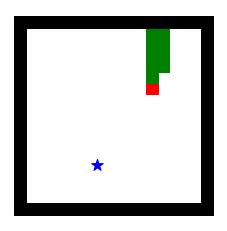

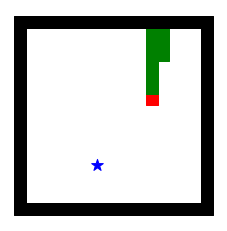

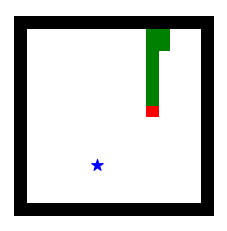

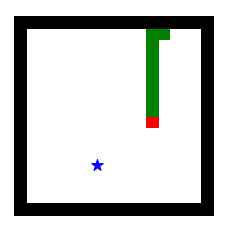

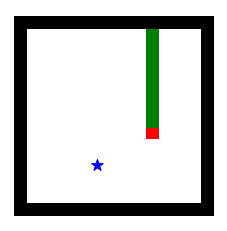

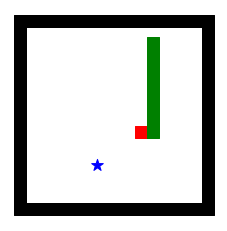

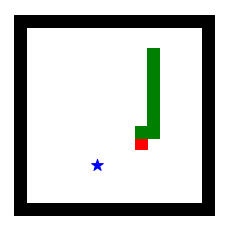

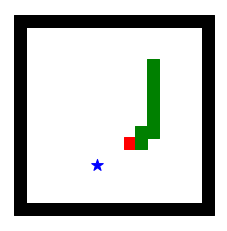

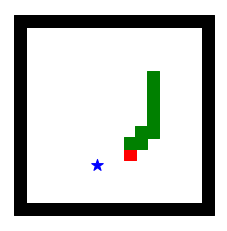

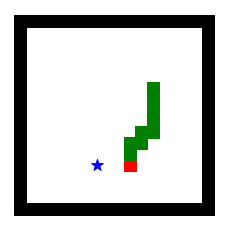

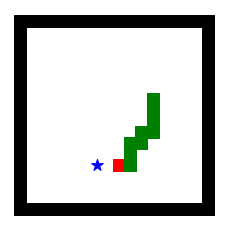

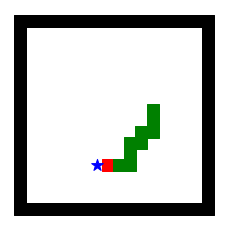

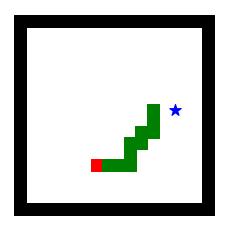

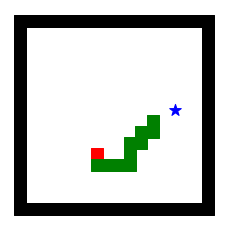

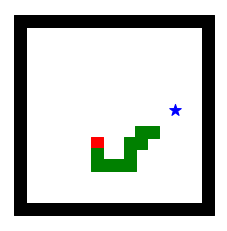

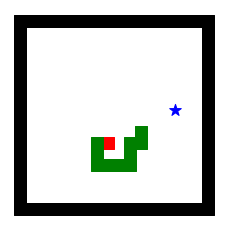

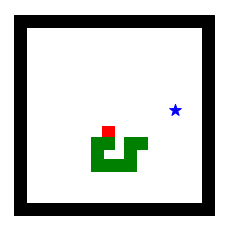

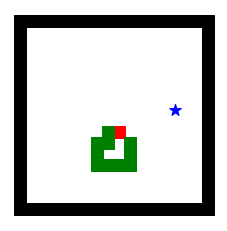

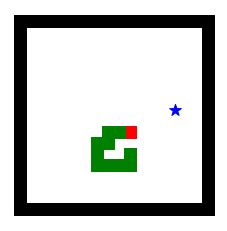

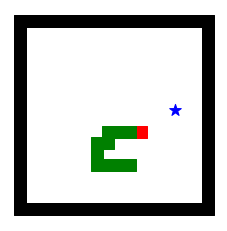

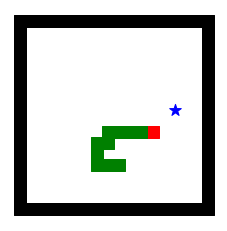

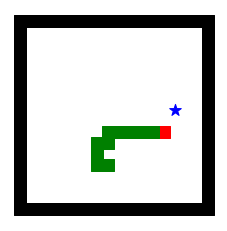

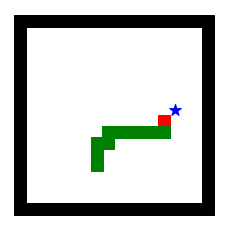

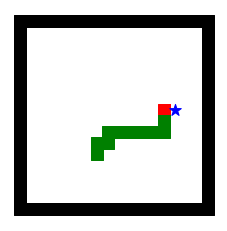

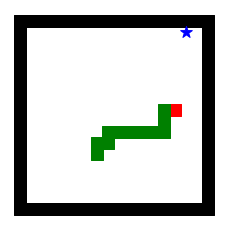

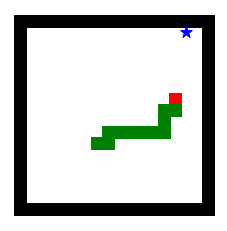

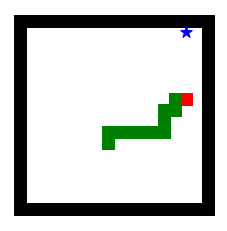

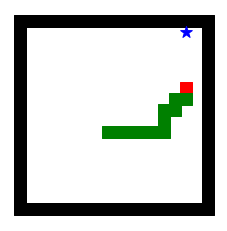

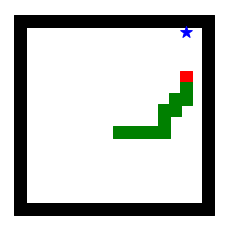

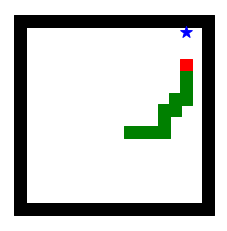

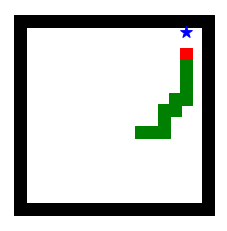

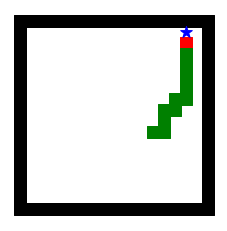

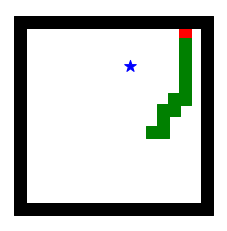

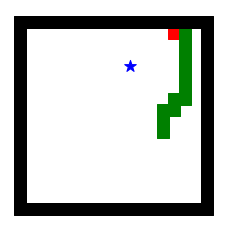

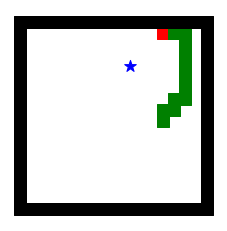

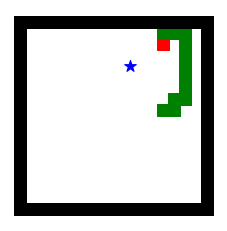

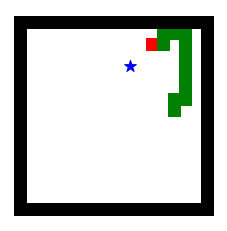

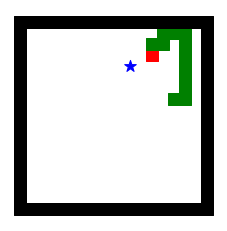

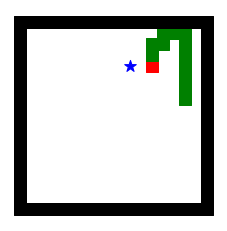

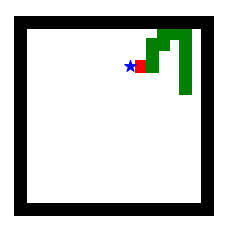

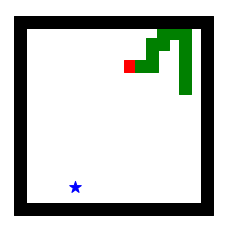

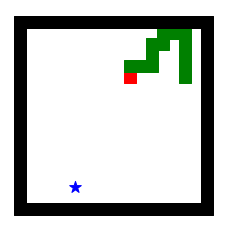

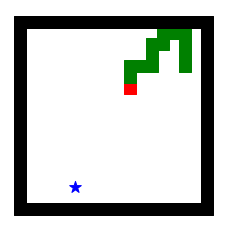

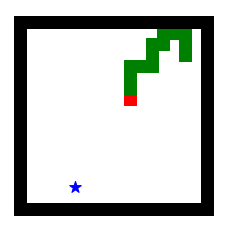

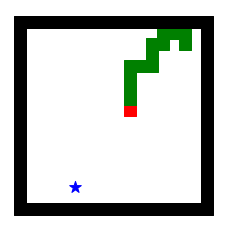

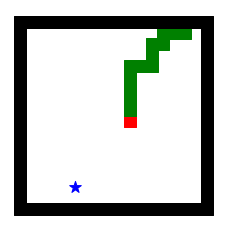

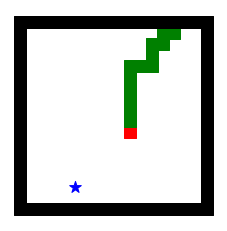

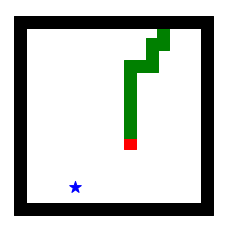

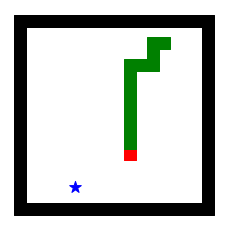

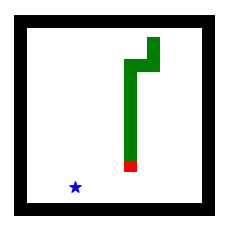

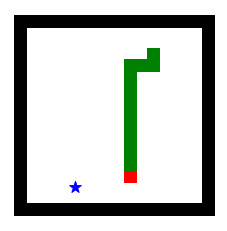

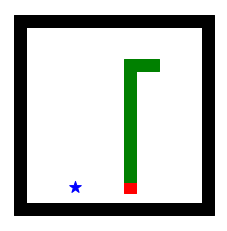

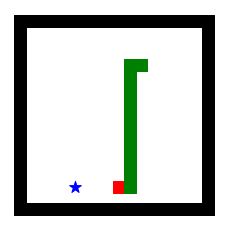

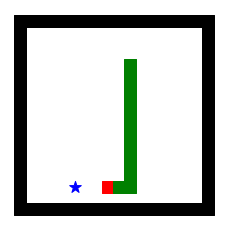

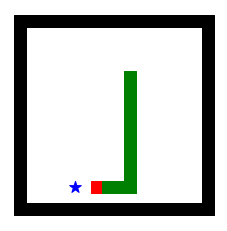

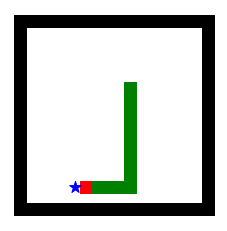

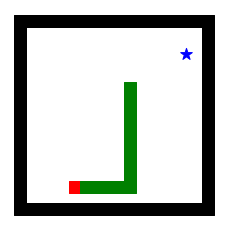

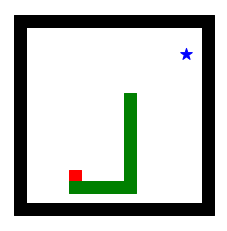

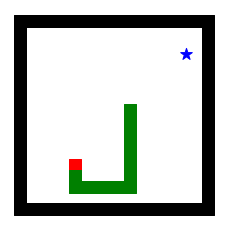

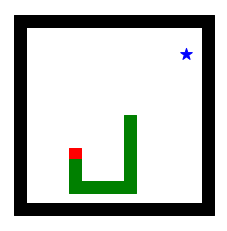

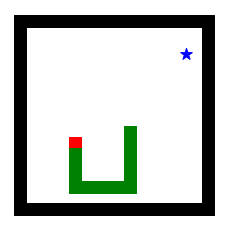

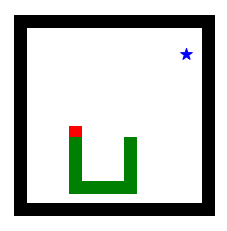

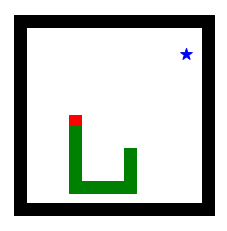

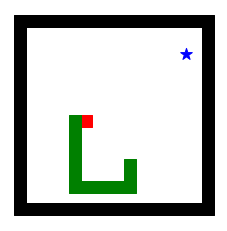

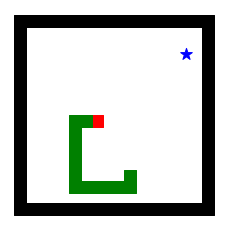

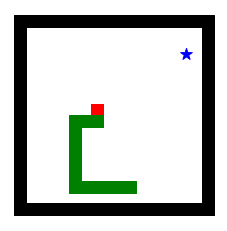

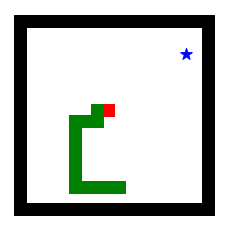

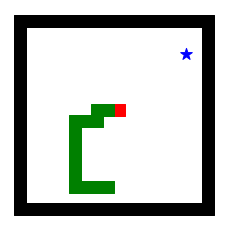

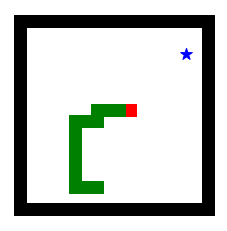

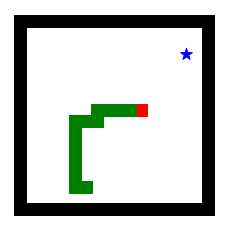

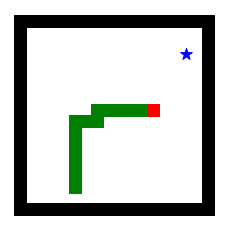

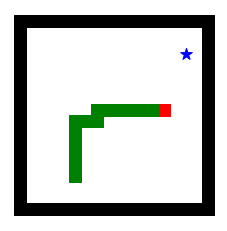

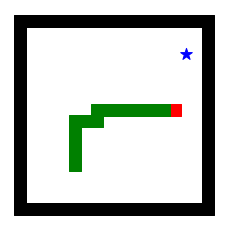

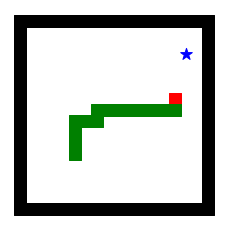

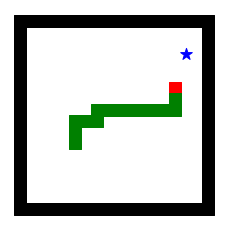

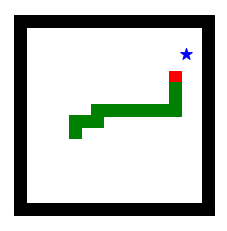

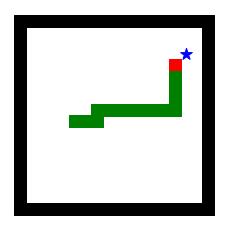

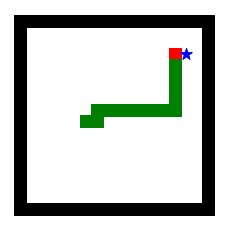

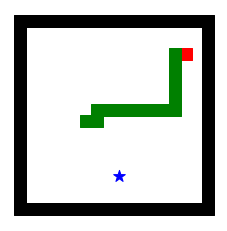

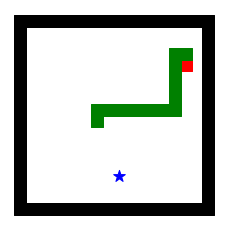

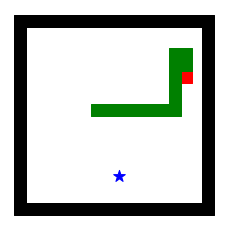

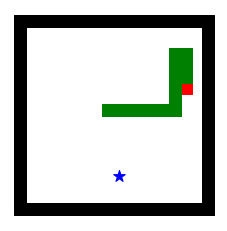

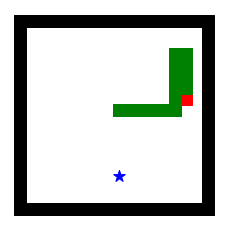

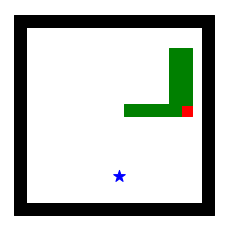

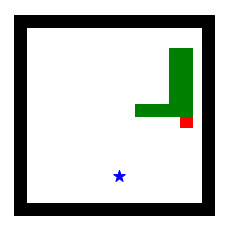

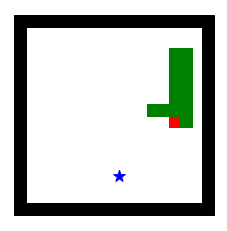

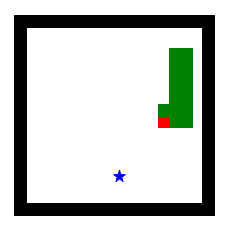

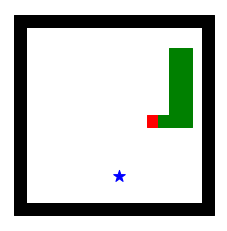

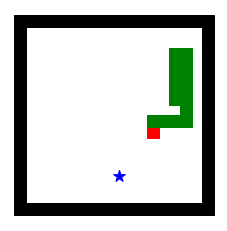

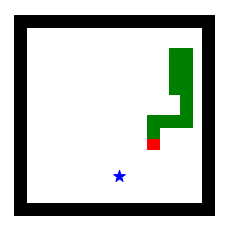

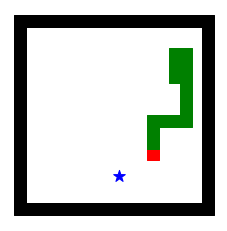

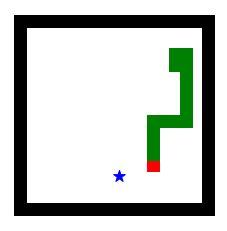

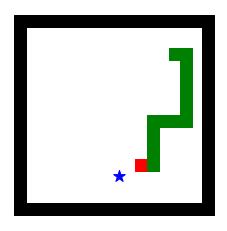

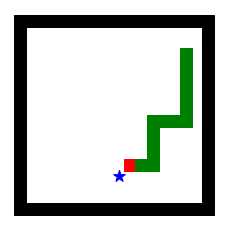

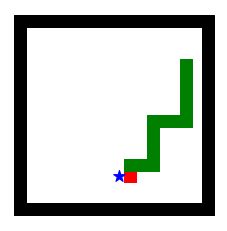

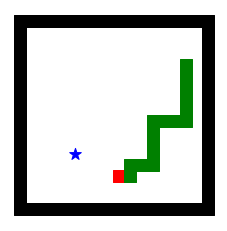

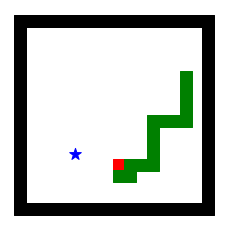

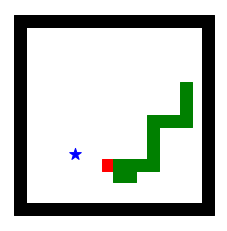

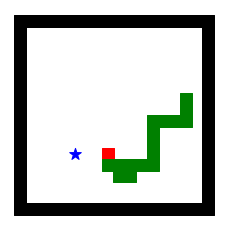

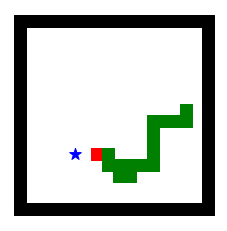

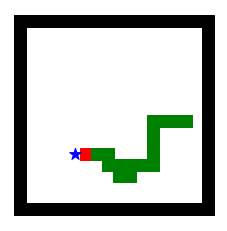

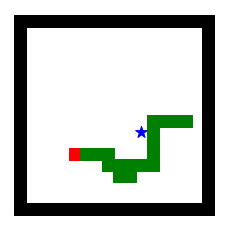

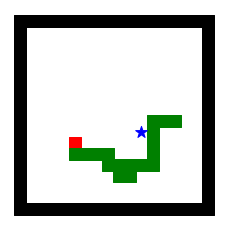

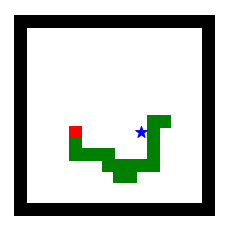

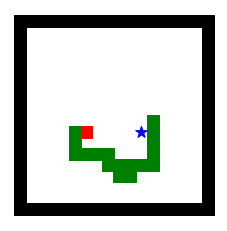

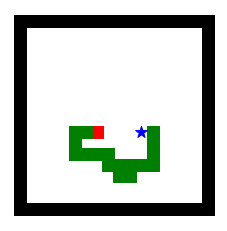

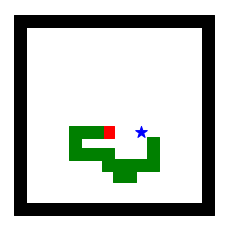

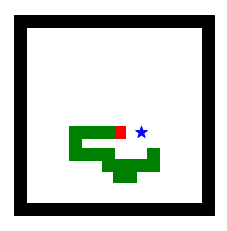

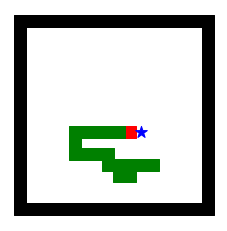

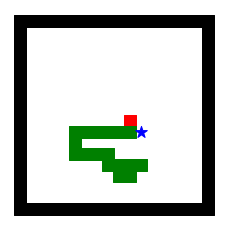

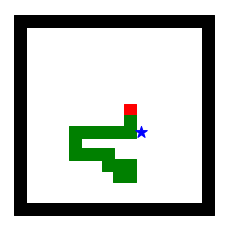

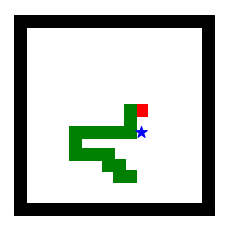

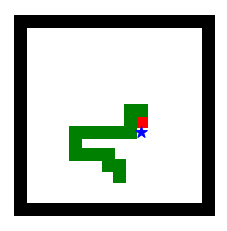

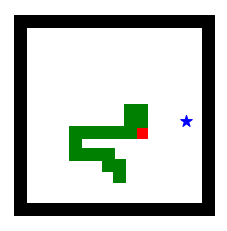

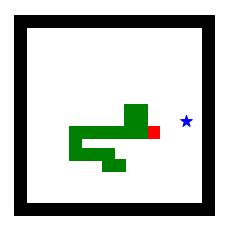

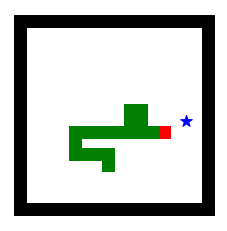

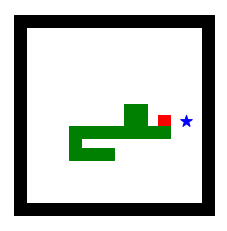

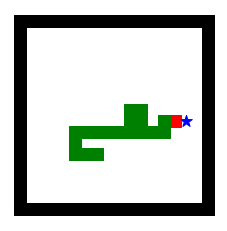

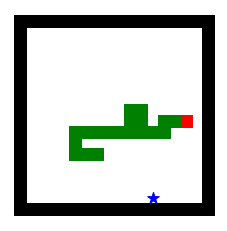

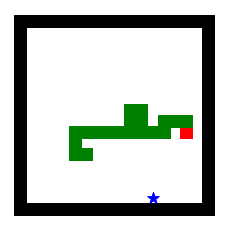

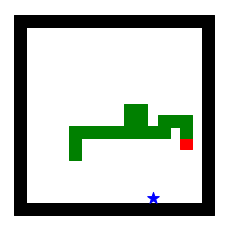

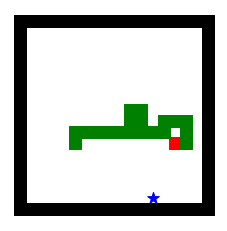

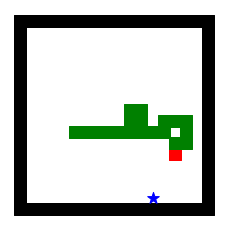

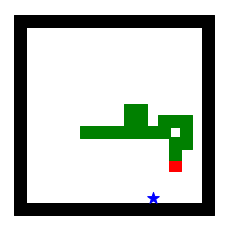

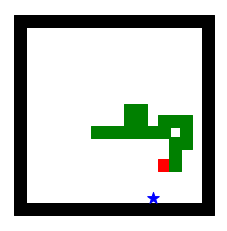

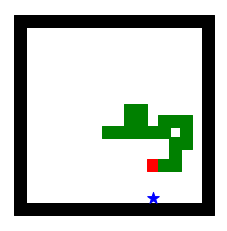

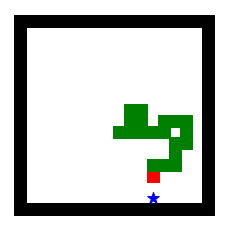

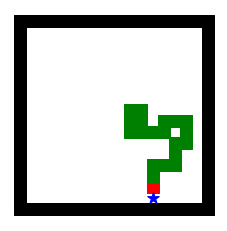

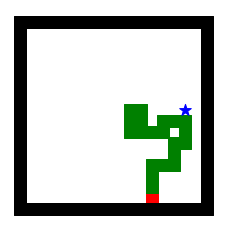

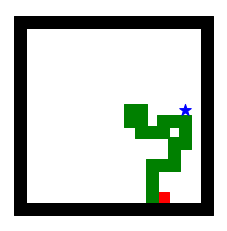

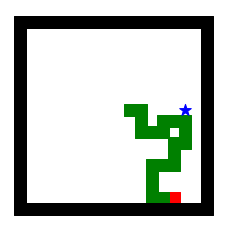

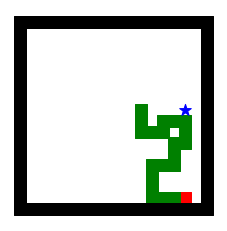

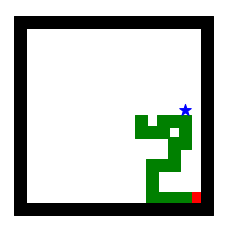

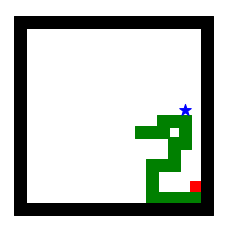

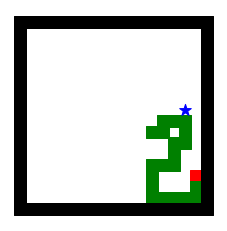

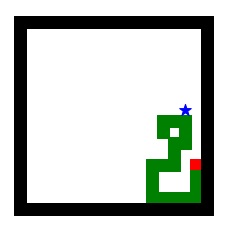

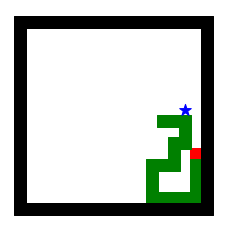

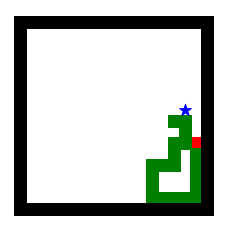

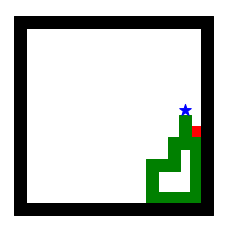

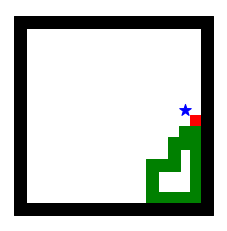

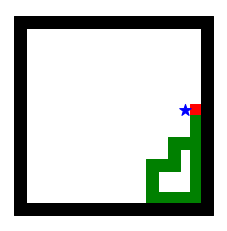

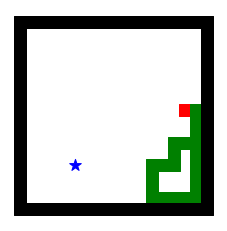

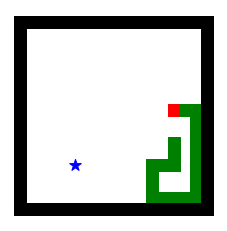

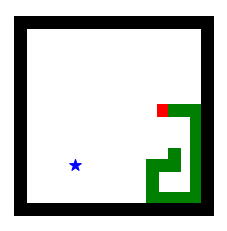

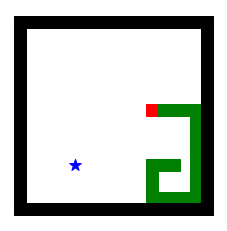

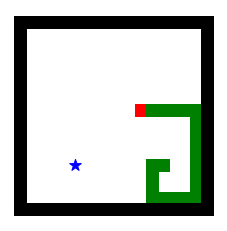

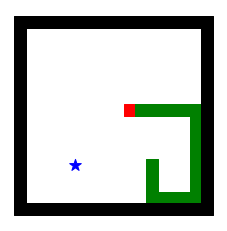

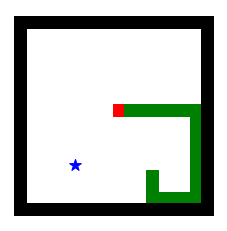

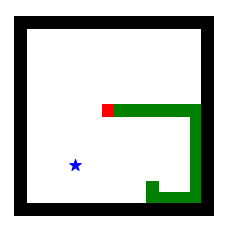

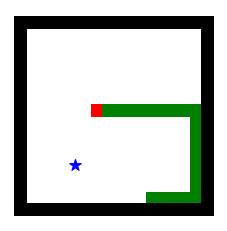

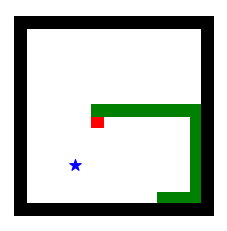

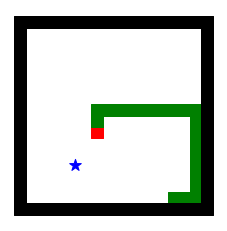

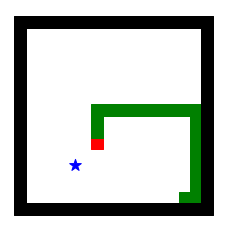

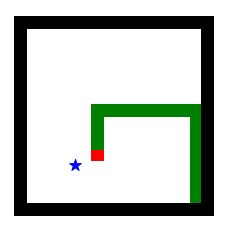

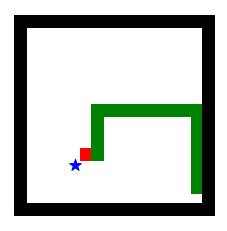

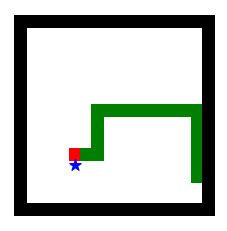

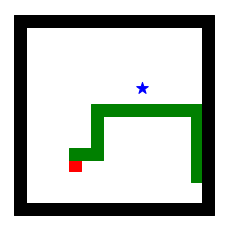

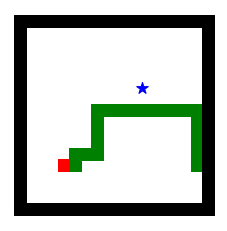

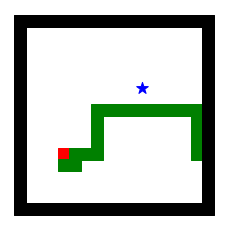

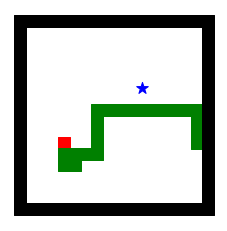

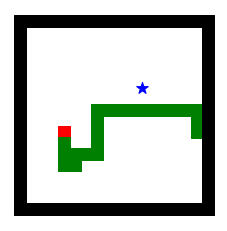

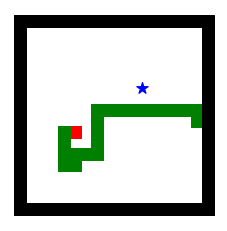

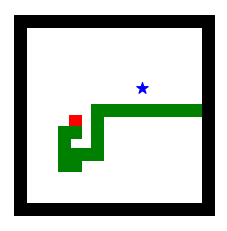

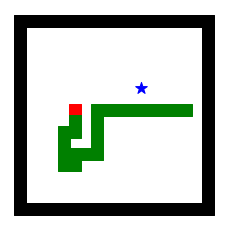

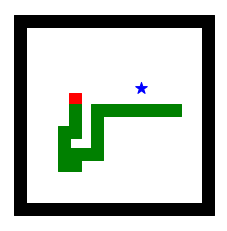

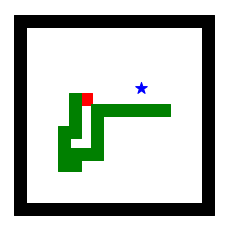

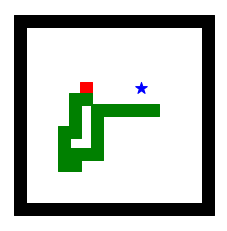

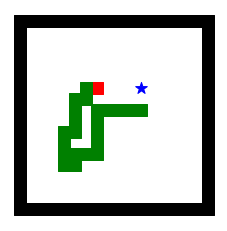

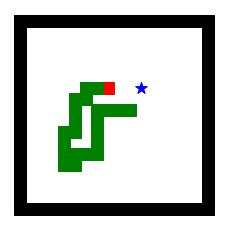

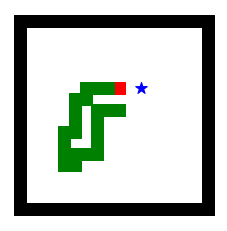

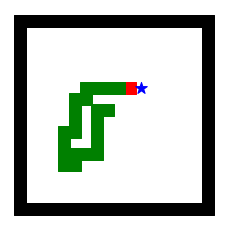

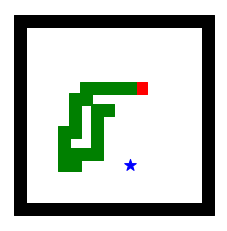

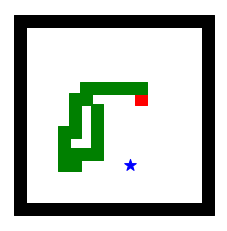

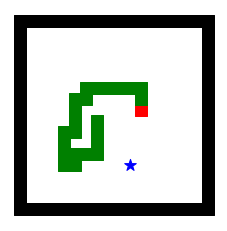

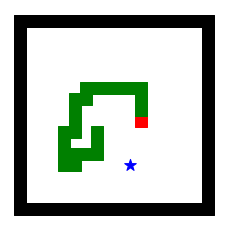

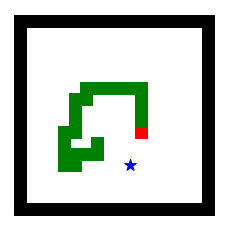

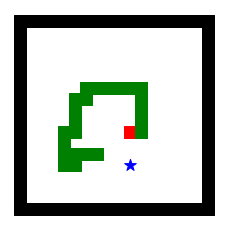

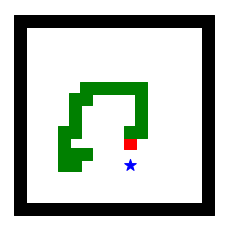

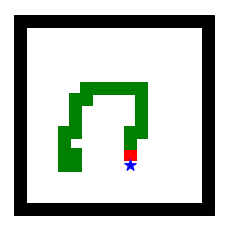

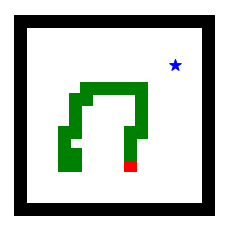

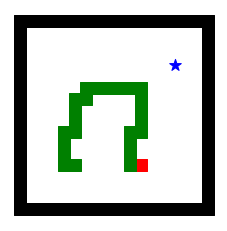

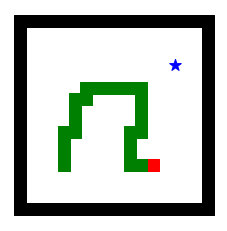

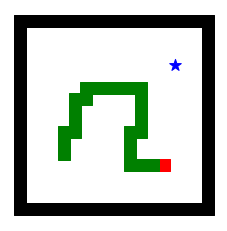

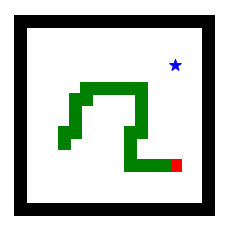

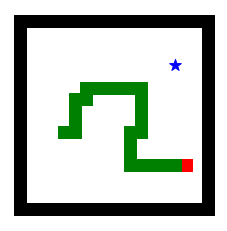

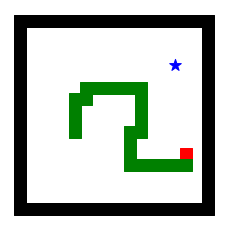

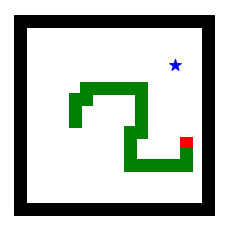

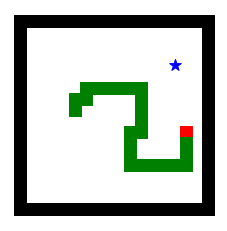

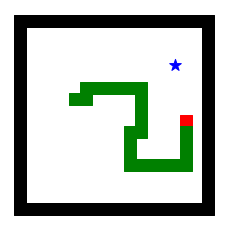

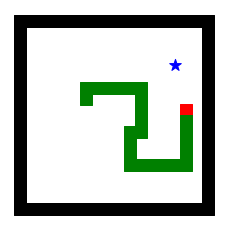

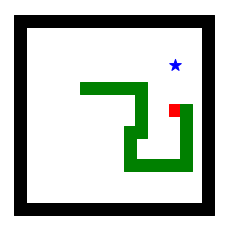

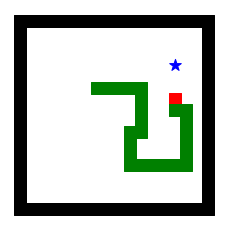

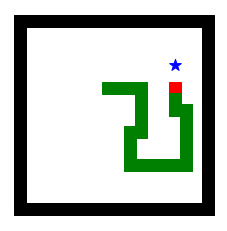

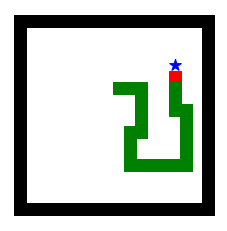

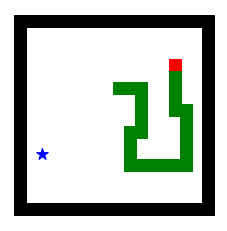

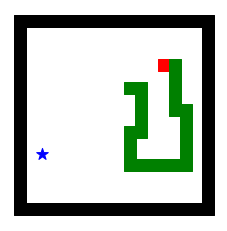

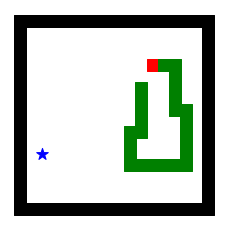

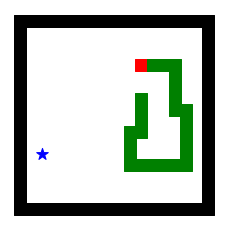

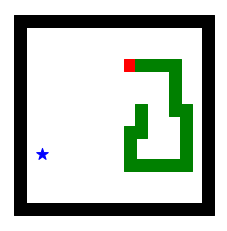

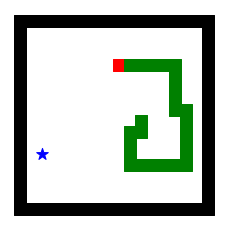

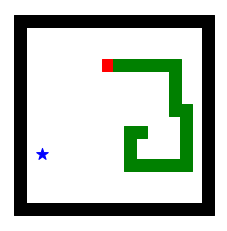

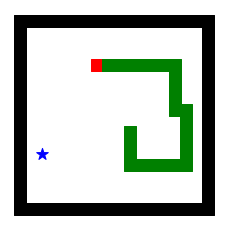

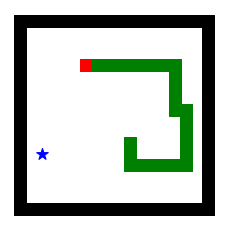

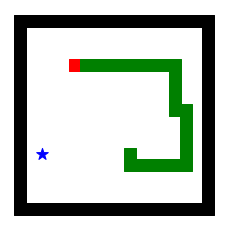

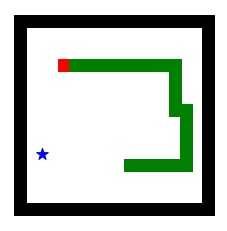

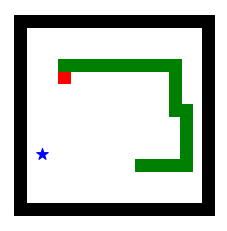

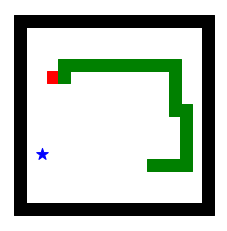

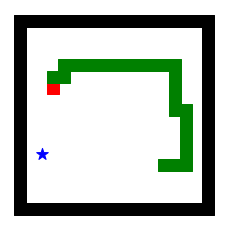

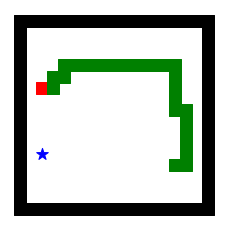

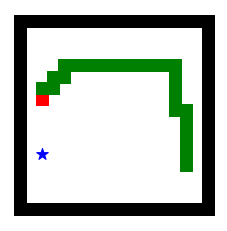

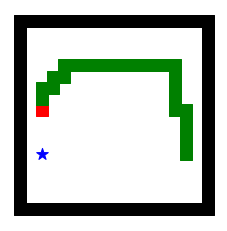

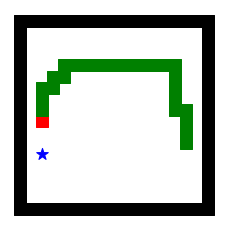

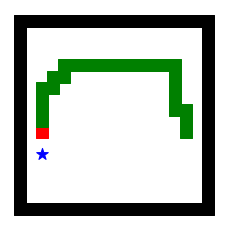

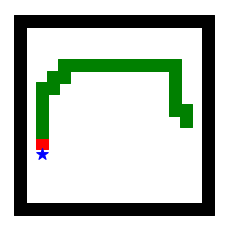

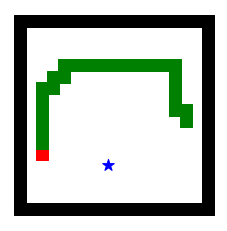

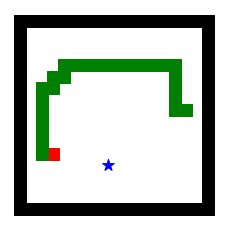

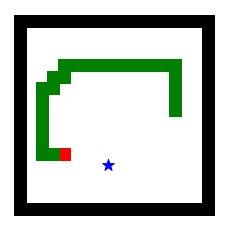

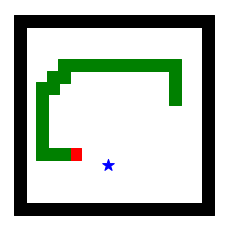

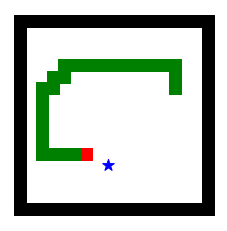

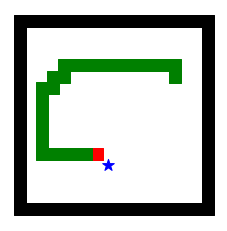

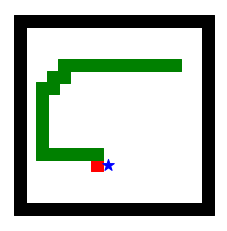

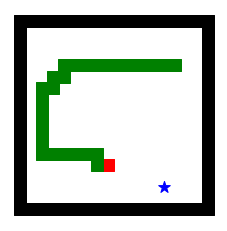

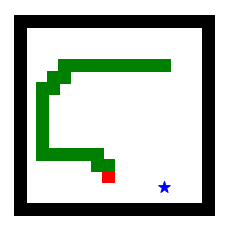

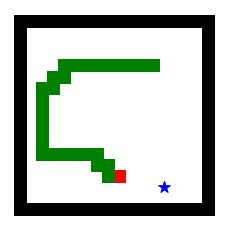

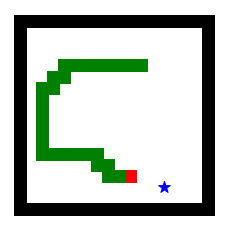

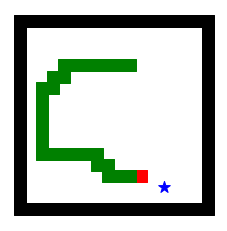

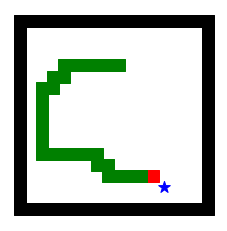

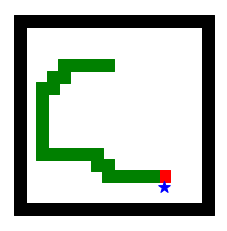

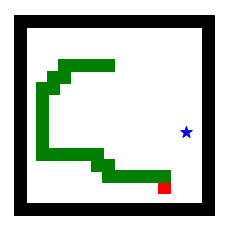

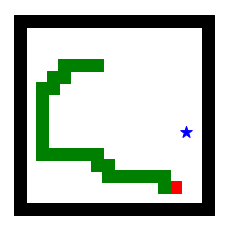

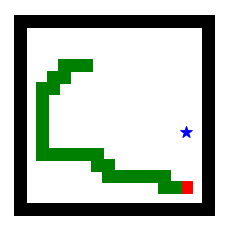

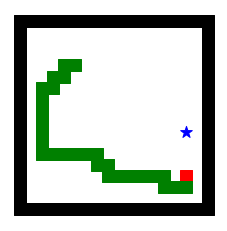

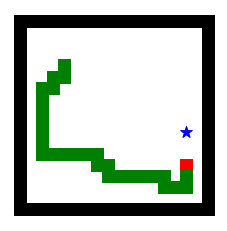

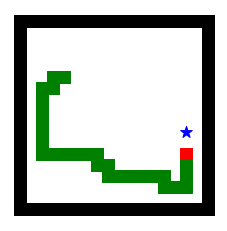

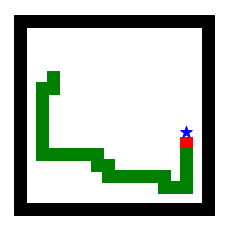

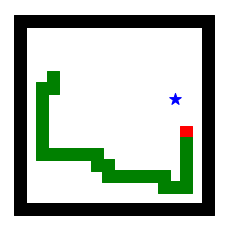

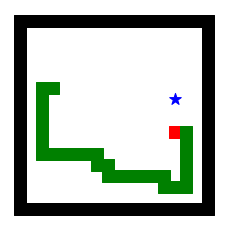

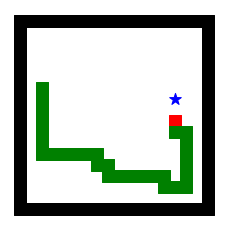

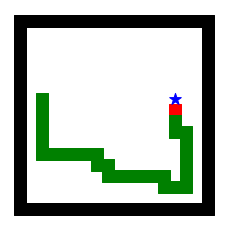

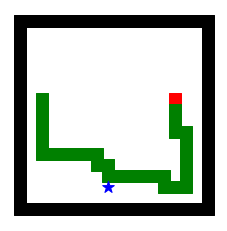

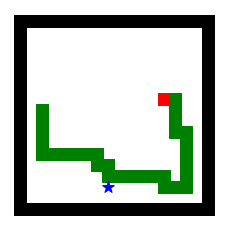

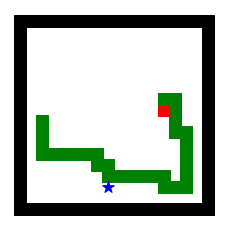

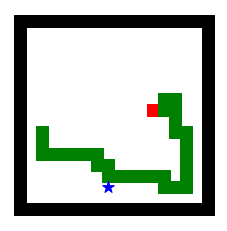

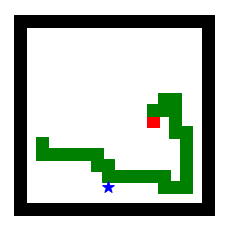

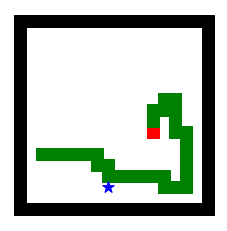

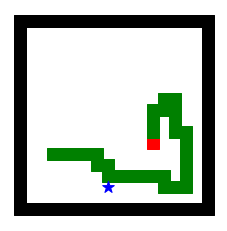

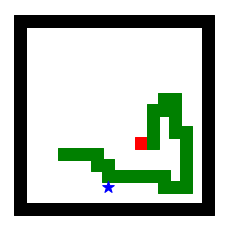

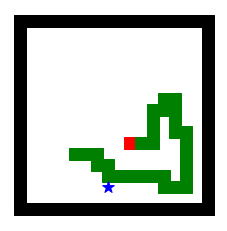

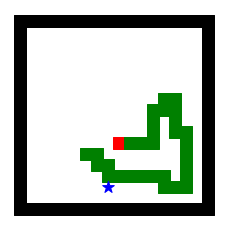

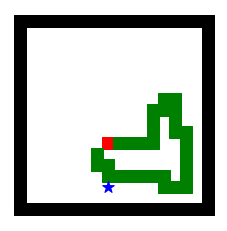

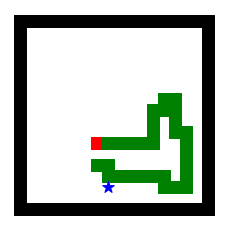

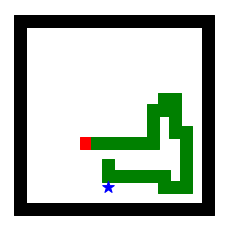

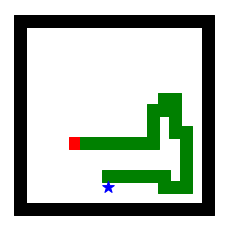

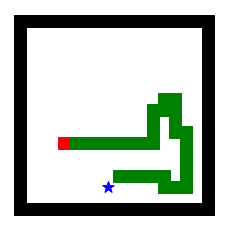

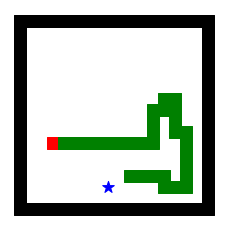

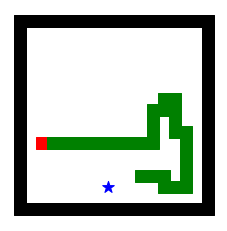

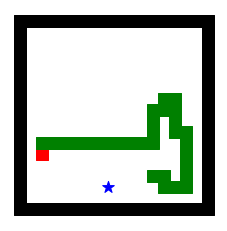

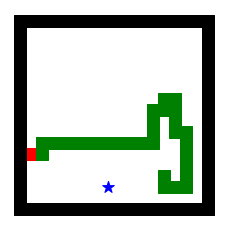

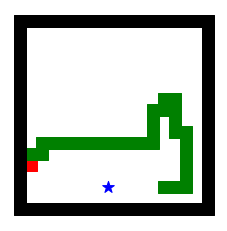

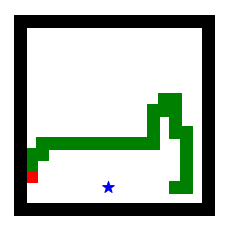

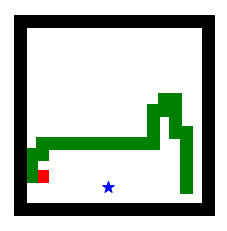

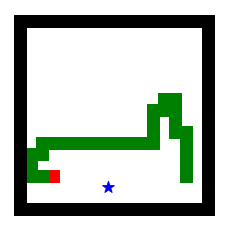

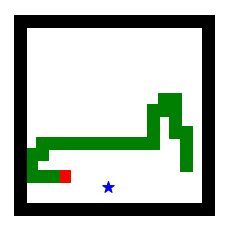

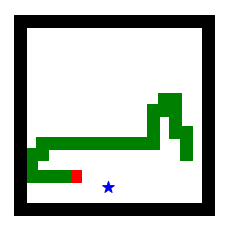

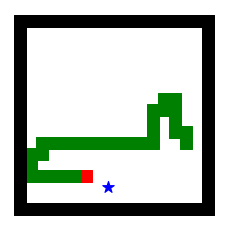

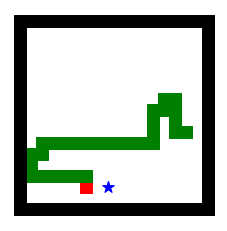

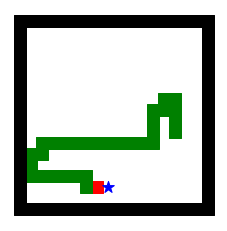

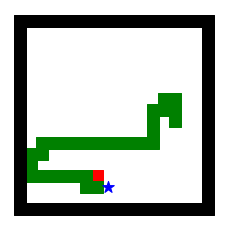

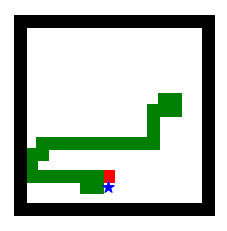

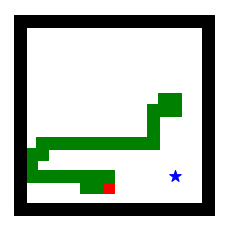

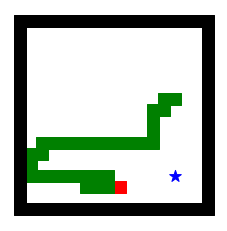

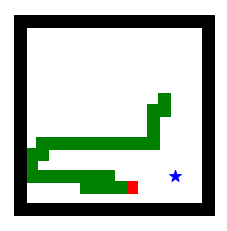

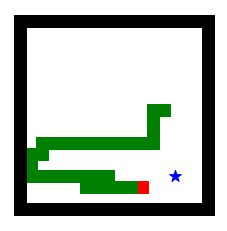

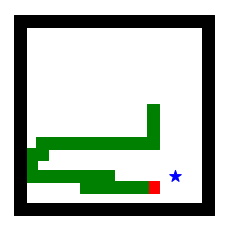

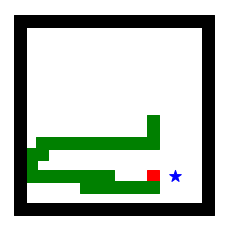

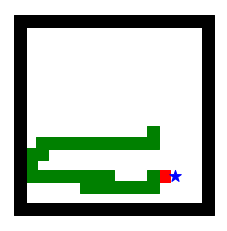

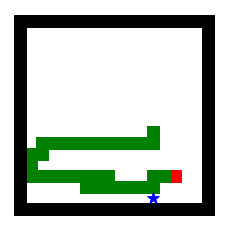

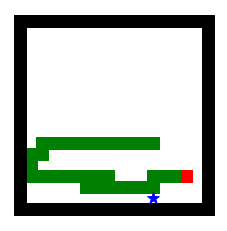

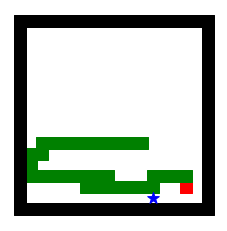

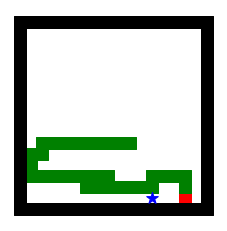

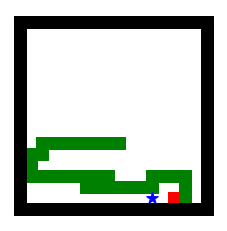

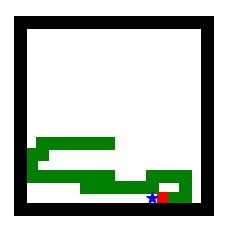

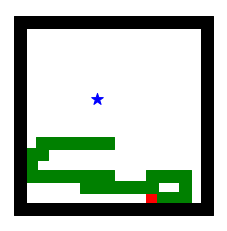

In [18]:


#plt.cla()
#plt.clf()
!mkdir ani_data 
!rm ani_data/*.png
for i,im in enumerate(ims):
    fig = plt.figure()
    plt.ion()
    plt.axis('off')
    plt.gca().set_aspect('equal')

    x,y = np.where(im==0)
    plt.scatter(x,y,c="w",marker="s",s=400, animated=True)
    
    x,y = np.where(im==2)
    plt.scatter(x,y,c="r",marker="s",s=150, animated=True)
    
    x,y = np.where(im==1)
    plt.scatter(x,y,c="g",marker="s",s=150, animated=True)
    
    x,y = np.where(im==-1)
    plt.scatter(x,y,c="k",marker="s",s=150, animated=True)
    
    x,y = np.where(im==3)
    plt.scatter(x,y,c="b",marker="*",s=150, animated=True)
    
    plt.savefig('ani_data/step'+str(i).zfill(5)+'.png', dpi = 128, bbox_inches="tight")
    
    #plt.clf()

In [19]:
!convert -delay 10 ani_data/*.png snake_animation.gif
!rm ani_data/*.png
!rm -r ani_data


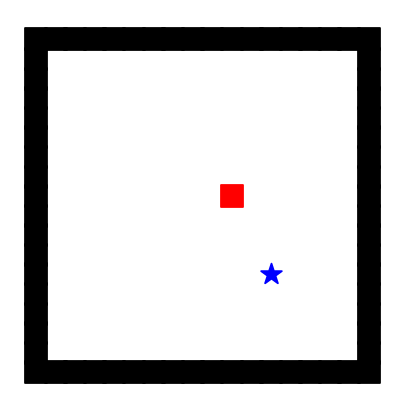

In [20]:
with open('snake_animation.gif','rb') as file:
    display(Image(file.read()))
    